# Causal Bandits
### Chris Botica and Nick Tyler

In [1]:
import numpy as np
from torch import tensor
from pyro import sample, do
import pyro.distributions as dist
from time import time
import matplotlib.pyplot as plt

### 1. Intro

We have a multi-armed bandit (2 arms/machines), each with it's own prior payout probability distribution. Our agent wants to maximize the reward

![Multi-armed Bandit](multiarmedbandit.jpg)

This problem is treated as if each machine has its own hidden probability distribution and the agent applies a sampling strategy to learn this distribution (explore) while trying to pull on the "best" arm to maximize rewards (exploit). 

There exists multiple sampling strategies that balance exploration and exploitation but, traditionally, all of these treat the each variable as fully observable. 

Example of such models:


![Traditional Models](imgs/Model1.png)

However, in our case, the environment as an unobserved confounder

![Our Model](imgs/Model2.png)

We treat the environment as 2 confounders. In our problem, the casino manipulated the payout probabilites for each machine based on the users drunkness and whether or not the machine is blinking:

![Our Model with Blink Drunk](imgs/Model3.png)

The casino decides on the following payout probabilities for the machines as a function of the agent's drunkness, the machine's blinkiness, and the arm choice:  

![Table](imgs/Probs_table.png)

### 2. Environment

In this model, we assume:
- the gambler has an equal chance of being drunk 
- each machine has an equal chance of blinking at any time. 

We have the following probabilities for the drunk, blink:

In [2]:
# Setup the environment
environment_probs = {
    'drunk': .5,
    'blinking': .5
}

Using these probabilities, we model the environment in our Environment class

In [3]:
class Environment(object):
    """
    Class that generates the environment for each player/machine.
    methods: .observe() generative model 

    parameters: 
        end_probabilities: probability of gambler being drunk and
        of machine blinking
    """

    def __init__(self, env_probabilities):
        self.env_probabilities = env_probabilities

    def observe(self):
        env = {}
        for key, value in self.env_probabilities.items():
            env[key] = sample(key, dist.Categorical(tensor([1 - value, value])))
        return env

We set our environment:

In [4]:
environment = Environment(environment_probs)

### 3. Bandit Simulator

Based on the probability table above, the casino has the following hidden reward probabilities:

In [5]:
causal_bandit_probs = np.array([
    np.array([
        np.array([.1, .5]),
        np.array([.4, .2])
    ]),
    np.array([
        np.array([.5, .1]),
        np.array([.2, .4])
    ])
])

We use these and the environment to make our bandit simulator class to simulate bandit feedback.

**Intuition:** The casino observes that the players have a natural tendancy towards certain machines. We call this intuition. Given the Drunk and Blinking variables for a player and the machines, we model the player's intuition using the xor function.
\begin{align} intuition = xor(Drunk, Blinking)\end{align}

In [6]:
class ConfoundingBanditSimulator(object):
    """
    Bandit Simulator with .gambler_model() method

    parameters: 
        reward_probabilities: hidden probability table set by casino
        environment: an environment that can be .observe for variables
    """

    def __init__(self, reward_probabilities):
        self.reward_probabilities = reward_probabilities

    def gambler_model(self, environment):  
        drunk = int(environment["drunk"])
        blinking = int(environment["blinking"])
        intuition = int(bool(drunk) ^ bool(blinking))  # xor(drunk, blinking)

        # Select arm based on intuition
        arm = sample('arm',dist.Delta(tensor(intuition)))

        # Get Reward
        reward_probability = self.reward_probabilities[arm][drunk][blinking]
        reward = sample('reward', dist.Bernoulli(reward_probability))

        return reward

    def __len__(self):
        return len(self.reward_probabilities)

Set our bandit simulator:

In [7]:
confoundingBandits = ConfoundingBanditSimulator(causal_bandit_probs)

### 4. Sampler

BaseSampler as a base for all our samplers

In [8]:
DRUNK = 'drunk'
BLINKING = 'blinking'


class BaseSampler(object):
    """
    A base class used by more complex samplers.
    methods: 
        .initialize() 
        .sample_bandits()
        .observed_envs()

    parameters: 
        bandits: a bandit class with .pull method
        environment: an environment that can be .observe for variables
    """

    @staticmethod
    def _get_init_array(n):
        return np.zeros(n)

    def __init__(self, bandits, environment):
        self.bandits = bandits
        self.environment = environment
        self.wins = self.__class__._get_init_array(len(self.bandits))
        self.trials = self.__class__._get_init_array(len(self.bandits))
        self.N = 0
        self.choices = []
        self.current_scores = []
        self.observed_envs = []

    def initialize(self):
        self.wins = self.__class__._get_init_array(len(self.bandits))
        self.trials = self.__class__._get_init_array(len(self.bandits))
        self.N = 0
        self.choices = []
        self.current_scores = []
        self.observed_envs = []

    def update_parameters(self, choice, result, observed_env):
        self._update_wins_trials(choice, result, observed_env)
        self.current_scores.append(result)
        self.N += 1
        self.choices.append(choice)
        self.observed_envs.append(observed_env)

    def _update_wins_trials(self, choice, result, observed_env):
        self.wins[choice] += result
        self.trials[choice] += 1

    def sample_bandits(self, n=1):
        for k in range(n):
            self._pull_bandit()

    def _pull_bandit(self):
        observed_env = self.environment.observe()
        algo_choice = self._select_arm(observed_env)
        model = self.bandits.gambler_model
        intervention_model = do(model, {'arm':algo_choice})
        result = intervention_model(observed_env)
        self.update_parameters(algo_choice, result, observed_env)

    def _select_arm(self, observed_env):
        return 0
    

#### 4.1. Standard Thompson Sampling

The standard Thompson Sampling algorithm ingores the player's intuition and, thus, doesn't take into account the environment. It assumes the following SCM:

![Our Model](imgs/StndTS_model.png)

Given the number of wins and losses for each machine, Standard Thompson Sampling chooses the machine $i$ that maximizes $P(Reward = 1 | Machine = i)$. This can be calculated by choosing the argument that maximizes the updated Beta distribution: 
\begin{align} choice = argmax_i( sample(Beta(successes_i, failures_i))  ) \end{align}
where $i$ is the machine.

Instead of doing pyro.inference to find this probability, we can simply use the posterior predictive of the Beta-Bernoulli distribution to model payout probabilities. That is,
\begin{align} choice = argmax_i \Big( \frac{successes_i}{successes_i+failures_i}  \Big) \end{align}

In [9]:
class StandardThomspon(BaseSampler):
    """
    Standard Thompson Sampling that returns arm choice.
    parameters: BaseSampler        
    
    """
    def _select_arm(self, observed_env):
        alpha = 1 + self.wins
        beta = 1 + self.trials - self.wins
        
        choice = np.argmax([alpha[0]/(alpha[0]+beta[0]), alpha[1]/(alpha[1]+beta[1])])
                            
        return choice

#### 4.2. Causal Thompson Sampling

In Causal Thompson sampling, we make the confounders explicit in our SCM. To enable the agent to pick to best arm, ideally, we would calculate $P(Reward = 1 | do(Machine = intuition))-P(Reward = 1 | do(Machine = counterintuition))$. However, observational data $P(Reward|Machine)$ does not support this. Instead, we calculate the Effect of the Treatment on the Treated ($ETT$).

To do so, we use the following:

\begin{align*}
P(R_{M = intuition}| do(M = intuition)) = P(R | M = intuition)  
\end{align*}
and
\begin{align*}
P(R_{M = intuition}| do(M = counter)) &= \sum_{d,b} P(R_{M = intuition}, D=d, B=b | M = counter)  \\
                                      &= \sum_{d,b} P(R_{M = intuition}| D=d, B=b, M = counter)P(D=d, B=b | M = counter) \\
                                    &= \sum_{d,b} P(R_{M = intuition}| D=d, B=b, M = intuition)P(D=d, B=b | M = counter) \\
                                    &= \sum_{d,b} P(R| D=d, B=b, M = intuition)P(D=d, B=b | M = counter) \\
\end{align*}

Let $Q_1  =  \sum_{d,b} P(R| D=d, B=b, M = intuition)P(D=d, B=b | M = counter)$ and $Q_2 = P(R | M = intuition)$. Thus, the $ETT$ will be $ETT=Q_2 - Q1$

Similar to the Standard Thompson algorithm, we choose the argument that maximizes the updated Beta distribution. However, we weigh each argument using the $ETT$, based on Bareinboim et. al., as follows:
- We initialize the weights: $w=[1,1]$
- Compute the weighting strength: $bias = 1 - |Q_1-Q_2|$
- Choose which arm to bias: **if** $Q_1>Q_2$ **then** $w[intuition] = bias$, **else**  $w[counter]=bias$
- Choose arm: $\alpha_i=$ # successes when choosing intuition on machine i, $\beta_i=$ # failures when choosing intuition on machine i. Then: $choice = argmax_i( sample(Beta(1+\alpha_i, 1+\beta_i))*w[machine_i] )$


In [10]:
class CausalThomspon(BaseSampler):
    """
    Causal Thompson Sampling that returns arm choice.
    parameters: BaseSampler     
    
    """
    @staticmethod
    def _get_init_array(n):
        return np.array([
            np.array([np.zeros(n), np.zeros(n)]),
            np.array([np.zeros(n), np.zeros(n)])
        ])

    def _update_wins_trials(self, choice, result, observed_env):
        drunk = observed_env[DRUNK]
        blinking = observed_env[BLINKING]
        self.wins[drunk][blinking][choice] += result
        self.trials[drunk][blinking][choice] += 1

    # Calculate P(Y=1 | X=x, Drunk = d, Blinking = b)
    def _cond_prob_y(self, x, d=-1, b=-1):
        if d == b == -1:  # meanining only condition on x
            y_vals = [self.current_scores[i] for i, x_val in enumerate(self.choices) if x_val == x]
        else:
            y_vals = [self.current_scores[i] for i, (x_val, env) in enumerate(zip(self.choices, self.observed_envs))
                      if x_val == x and env[DRUNK] == d and env[BLINKING] == b]

        if len(y_vals) == 0:
            return 0
        else:
            return sum(y_vals) / len(y_vals)

    # Calculate P(Drunk=d & Blink=b | X=x)
    def _cond_prob_db(self, d, b, x):
        no_events = np.sum([1 for i, (x_val, env) in enumerate(zip(self.choices, self.observed_envs))
                            if x_val == x and env[DRUNK] == d and env[BLINKING] == b])
        no_outcomes = np.sum([1 for i, x_val in enumerate(self.choices) if x_val == x])

        if no_outcomes == 0:
            return 0
        else:
            return no_events / no_outcomes

    def _select_arm(self, observed_env):
        # Get environment variables that we care about
        drunk = observed_env[DRUNK]
        blinking = observed_env[BLINKING]

        # Get the intuition for this trial:
        intuition = int(bool(drunk) ^ bool(blinking))  # xor(drunk, blinking)

        # Estimate the payout for the counter-intuition: E(Y_(X=x')|X=x)
        counter_intuition = abs(intuition - 1)
        Q1 = np.sum([self._cond_prob_y(counter_intuition, drunk_val, blink_val)
                     * self._cond_prob_db(drunk_val, blink_val, counter_intuition)
                     for drunk_val in [0, 1] for blink_val in [0, 1]])

        # Estimate the payout for the intuition (posterior predictive): P(y|X=x)
        Q2 = self._cond_prob_y(intuition)

        w = [1, 1]  # initialize weights 
        bias = 1 - abs(Q1 - Q2)  # 1-ETT (weight strength)

        if Q1 > Q2:
            w[intuition] = bias  # per the paper
        else:
            w[counter_intuition] = bias

        # Get the #successes and # failures for each machine given the intuition:
        
        # Since we store the successes as wins[drunk][blinking] I want to get the possible drunkess and
        # blinkness that would yield our intuition (2 posibilities since we are doing inverse of xor)
        env_given_intuition = [[drunk, blinking],
                               [abs(drunk - 1), abs(blinking - 1)]]
        # Thus, env_given_intuition[k] corresponds to the drunk&blink values
        # that yield that intuition
        
        wins = sum([self.wins[drunk][blinking] for drunk, blinking in env_given_intuition])
        trials = sum([self.trials[drunk][blinking] for drunk, blinking in env_given_intuition])
        alpha = 1 + wins
        beta = 1 + trials - wins

        # Choose arm:
        choice = np.argmax([sample('arm1', dist.Beta(alpha[0], beta[0])) * w[0],
                            sample('arm2', dist.Beta(alpha[1], beta[1])) * w[1]])
        
        

        return choice

Set our samplers:

In [11]:
standard_sampler = StandardThomspon(confoundingBandits, environment)
causal_sampler = CausalThomspon(confoundingBandits, environment)

### 5. Regret and Prob of picking best arm

In [12]:
def regret_causal(probabilities, choices):
    regret_arr = []
    last = 0
    for i in range(0, len(probabilities)):
        prob = probabilities[i]
        w_opt = prob.max()
        reg = w_opt - prob[choices[i]]
        regret_arr.append(reg + last)
        last = reg + last
    return np.array(regret_arr)

# Probability of Selecting Best Arm
def prob_best_arm_causal(probabilities, choices):
    was_best_selected = [int(np.argmax(prob)==choice) for _,(prob, choice) in enumerate(zip(probabilities, choices))]
    cumulative_best_selected = np.array(was_best_selected).cumsum()
    prob_best = [cumulative_best_selected[i]/(i+1) for i in range(len(cumulative_best_selected))]
    return prob_best

### 6. Run simulation

In [13]:
def run_simulation(trials, pulls, sampler, true_probabilities):
    exp_total_regret = np.zeros(pulls)
    exp_prob_best_arm = np.zeros(pulls)
    
    for trial in range(trials):
        sampler.initialize()
        sampler.sample_bandits(pulls)
        
        pull_probabilities = [
            true_probabilities[int(env['drunk'])][int(env['blinking'])]
            for env in sampler.observed_envs
        ]
        
        exp_total_regret += regret_causal(pull_probabilities, sampler.choices)
        exp_prob_best_arm += prob_best_arm_causal(pull_probabilities, sampler.choices)
    
    return exp_total_regret, exp_prob_best_arm
        
        

n_pulls = 1000 # number pulls for a trial
n_trials = 10 # number of trials/times we repeat the experiment to get E[regret]

exp_tot_standard_regret, exp_standard_prob_best_arm = run_simulation(
    n_trials, n_pulls, standard_sampler, causal_bandit_probs
)
exp_tot_causal_regret, exp_causal_prob_best_arm = run_simulation(
    n_trials, n_pulls, causal_sampler, causal_bandit_probs
)

Plot Regret

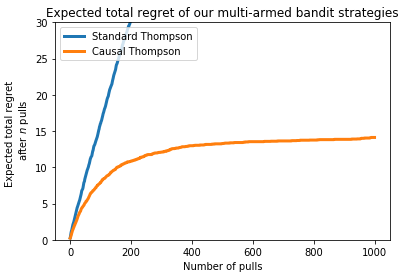

In [14]:
StandardTS_regret_plot = plt.plot(np.divide(exp_tot_standard_regret,n_trials), lw =3,
                         label = "Standard Thompson")
CausalTS_regret_plot = plt.plot(np.divide(exp_tot_causal_regret,n_trials), lw =3,
                       label = "Causal Thompson")
plt.ylim(bottom=0,top = 30)
plt.title("Expected total regret of our multi-armed bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Expected total regret \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()

Plot Prob of selecting best arm

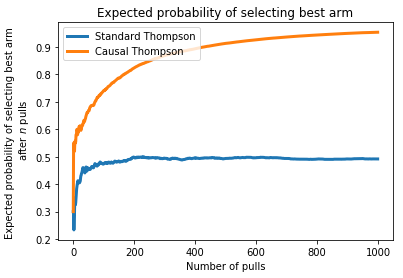

In [15]:
StandardTS_prob_plot = plt.plot(np.divide(exp_standard_prob_best_arm,n_trials), lw =3,
                         label = "Standard Thompson")
CausalTS_prob_plot = plt.plot(np.divide(exp_causal_prob_best_arm,n_trials), lw =3,
                       label = "Causal Thompson")
plt.title("Expected probability of selecting best arm")
plt.xlabel("Number of pulls")
plt.ylabel("Expected probability of selecting best arm \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()